In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json
import random
import sys

/home/user/Git/ecommerce-segments/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Read Data

In [3]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [4]:
read_query = make_read_query()

In [5]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,fav_category,fav_cat_purchases,fav_cat_avg_item_value,fav_cat_freq_strength,fav_cat_spending_strength,order_items,loyalty_segment,order_value_segment,category_choice_segment,lifetime_status
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,Jeans,1.0,74.99,0.00,0.000000,"{""(70373,\""WranglerÂ® Booty Up Stretch Jean fo...",None,None,None,None
1,9418,69,F,United Kingdom,Cardiff,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,Outerwear & Coats,1.0,399.00,0.50,0.900677,"{""(90353,\""Colleen Skirt Slip\"",Women,Intimate...",None,None,None,None
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,Blazers & Jackets,1.0,169.98,0.25,0.696811,"{""(27173,\""Modadorn New Arrivals Spring & fall...",None,None,None,None
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,Fashion Hoodies & Sweatshirts,1.0,51.96,0.50,0.722168,"{""(49470,\""Billabong Men's Semi-Button Up Stri...",None,None,None,None
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,None,NaN,NaN,NaN,NaN,None,None,None,None,None


In [6]:
order_items_enriched = read_query("SELECT * FROM order_items_enriched")
order_items_enriched.head()

SELECT * FROM order_items_enriched 



,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,...,product_category,product_department,product_brand,product_name,distribution_center,user_age,user_gender,user_county,user_city,user_traffic_source
0,1,1,1,2953,3,Shipped,2022-07-20 10:32:05,2022-07-20 16:42:00,NaT,NaT,...,Active,Women,Tommy Hilfiger,Tommy Hilfiger Women's 3 Pack Sports Crew,Memphis TN,62,F,South Korea,Bucheon City,Search
1,2,1,1,4731,7,Shipped,2022-07-20 11:05:38,2022-07-20 16:42:00,NaT,NaT,...,Jeans,Women,Joe's Jeans,Joe's Jeans Women's Skinny Jeans,Port Authority of New York/New Jersey NY/NJ,62,F,South Korea,Bucheon City,Search
2,3,1,1,7656,9,Shipped,2022-07-19 11:29:28,2022-07-20 16:42:00,NaT,NaT,...,Blazers & Jackets,Women,eVogues Apparel,Plus size Button Closure Cropped Bolero Jacket...,New Orleans LA,62,F,South Korea,Bucheon City,Search
3,4,2,2,25774,11,Complete,2022-02-20 10:28:57,2022-02-22 12:23:00,2022-02-23 18:29:00,NaT,...,Underwear,Men,Tommy Bahama,Tommy Bahama Tropical Print Boxer Short,Los Angeles CA,65,M,Brasil,Franca,Organic
4,5,3,3,22308,13,Processing,2023-04-23 09:04:57,NaT,NaT,NaT,...,Pants,Men,Dockers,Dockers Men's Limited Offer D2 Stretch Khaki Pant,Philadelphia PA,16,M,United States,Hallandale Beach,Organic


In [7]:
products = read_query("SELECT * FROM products")
products.head()

SELECT * FROM products 



,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,13842,2.52,Accessories,Low Profile Dyed Cotton Twill Cap - Navy W39S55D,MG,6.25,Women,EBD58B8A3F1D72F4206201DA62FB1204,1
1,13928,2.34,Accessories,Low Profile Dyed Cotton Twill Cap - Putty W39S55D,MG,5.95,Women,2EAC42424D12436BDD6A5B8A88480CC3,1
2,14115,4.88,Accessories,Enzyme Regular Solid Army Caps-Black W35S45D,MG,10.99,Women,EE364229B2791D1EF9355708EFF0BA34,1
3,14157,4.65,Accessories,Enzyme Regular Solid Army Caps-Olive W35S45D (...,MG,10.99,Women,00BD13095D06C20B11A2993CA419D16B,1
4,14273,6.51,Accessories,Washed Canvas Ivy Cap - Black W11S64C,MG,15.99,Women,F531DC20FDE20B7ADF3A73F52B71D0AF,1


# EDA

In [8]:
order_items_enriched.product_category.unique()

array(['Active', 'Jeans', 'Blazers & Jackets', 'Underwear', 'Pants',
       'Sleep & Lounge', 'Swim', 'Sweaters', 'Skirts', 'Shorts',
       'Accessories', 'Fashion Hoodies & Sweatshirts',
       'Suits & Sport Coats', 'Tops & Tees', 'Socks', 'Outerwear & Coats',
       'Dresses', 'Jumpsuits & Rompers', 'Maternity', 'Intimates',
       'Pants & Capris', 'Leggings', 'Plus', 'Socks & Hosiery', 'Suits',
       'Clothing Sets'], dtype=object)

In [9]:
products.groupby(['category', 'department']).first()

id   cost  \
category                      department                 
Accessories                   Men         28646   8.74   
                              Women       13842   2.52   
Active                        Men         18147  17.07   
                              Women        2848  20.95   
Blazers & Jackets             Women        7903  10.57   
Clothing Sets                 Women        8037  25.54   
Dresses                       Women        3206  38.31   
Fashion Hoodies & Sweatshirts Men         17159  28.43   
                              Women        2060   6.03   
Intimates                     Women       12216   9.01   
Jeans                         Men         21241  55.66   
                              Women        4330  21.17   
Jumpsuits & Rompers           Women        4169  59.68   
Leggings                      Women        5825  30.77   
Maternity                     Women       15178  27.24   
Outerwear & Coats             Men         23892  34.09   
                              Women        8754  38.08   
Pants                         Men         22561  49.01   
Pants & Capris                Women        5353  22.47   
Plus                          Women       15674   3.11   
Shorts                        Men         23312  27.33   
                              Women        6529  31.96   
Skirts                        Women        7234   9.20   
Sleep & Lounge                Men         27003   9.30   
                              Women        9674  21.10   
Socks                         Men         24644  27.87   
Socks & Hosiery               Women        9041  20.48   
Suits                         Women        8080  37.11   
Suits & Sport Coats           Men         20265  58.00   
Sweaters                      Men         19353  19.10   
                              Women         791  44.65   
Swim                          Men         27569  92.65   
                              Women       12777  16.69   
Tops & Tees                   Men         16875  25.58   
                              Women          70  56.92   
Underwear                     Men         25824  12.40   

                                                                                       name  \
category                      department                                                      
Accessories                   Men         4 Panel Large Bill Flap Hat W15S48B (One Size ...   
                              Women        Low Profile Dyed Cotton Twill Cap - Navy W39S55D   
Active                        Men                    2XU Non-Stirrup Compression Calf Guard   
                              Women                   2XU Women's Compression Recovery Sock   
Blazers & Jackets             Women       ICE (5066) ladies smart herring bone tweed jac...   
Clothing Sets                 Women       Jostar Short Sleeve Solid Stretchy Capri Pants...   
Dresses                       Women           AGB Women's Long Sleeve Striped Sweater Dress   
Fashion Hoodies & Sweatshirts Men         Independent Trading Co. Mens Sherpa Lined Full...   
                              Women       Next Level Apparel Ladies Juniors' Soft Therma...   
Intimates                     Women       Lace Bra and Panty Set Neon Pink Neon Yellow B...   
Jeans                         Men                                      Mavi Men's Matt Jean   
                              Women                    YMI Juniors Five Pocket Jegging Jean   
Jumpsuits & Rompers           Women       Women's KC and Friends Detachable Apron Romper...   
Leggings                      Women                          Chyor Leggings For Spring Fall   
Maternity                     Women                      Boob Designs Fast Food Nursing Bra   
Outerwear & Coats             Men         Wilda Men's Military Wool Peacoat w/ Chest Poc...   
                              Women                     ASICS Women's Thermopolis LT Jacket   
Pants                         Men  

In [10]:
meta_category_map = {
    'Suits': 'Suits & Blazers',
    'Suits & Sport Coats': 'Suits & Blazers',
    'Blazers & Jackets': 'Suits & Blazers',
    'Fashion Hoodies & Sweatshirts': 'Casual Top',
    'Jeans': 'Casual Bottom',
    'Pants': 'Casual Bottom',
    'Pants & Capris': 'Casual Bottom',
    'Shorts': 'Casual Bottom',
    'Sweaters': 'Casual Top',
    'Tops & Tees': 'Casual Top',
    'Leggings': 'Casual Bottom',
    'Socks & Hosiery': 'Socks',
    'Active': 'Active & Swim',
    'Swim': 'Active & Swim',
    'Accessories': 'Accessories & Plus',
    'Plus': 'Accessories & Plus',
    'Intimates': 'Intimates & Underwear',
    'Underwear': 'Intimates & Underwear',
    'Clothing Sets': 'Women Fashion',
    'Dresses': 'Women Fashion',
    'Jumpsuits & Rompers': 'Women Fashion',
    'Skirts': 'Women Fashion',
}

In [11]:
order_items_enriched['meta_category'] = order_items_enriched.product_category.apply(lambda x: meta_category_map.get(x, x))

In [12]:
order_items_enriched.meta_category.unique()

array(['Active & Swim', 'Casual Bottom', 'Suits & Blazers',
       'Intimates & Underwear', 'Sleep & Lounge', 'Casual Top',
       'Women Fashion', 'Accessories & Plus', 'Socks',
       'Outerwear & Coats', 'Maternity'], dtype=object)

In [63]:
X_cats = order_items_enriched.pivot_table(index='user_id', columns=['product_department', 'product_category'], values='id', aggfunc='count', fill_value=0)
X_cats.columns = ['_'.join(col) for col in X_cats.columns]
X_cats

,Men_Accessories,Men_Active,Men_Fashion Hoodies & Sweatshirts,Men_Jeans,Men_Outerwear & Coats,Men_Pants,Men_Shorts,Men_Sleep & Lounge,Men_Socks,Men_Suits & Sport Coats,...,Women_Pants & Capris,Women_Plus,Women_Shorts,Women_Skirts,Women_Sleep & Lounge,Women_Socks & Hosiery,Women_Suits,Women_Sweaters,Women_Swim,Women_Tops & Tees
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
99996,1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
99998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1]
# select_idx = list(set(X_cats.index).intersection(repeat_purchasers.id))
# X_cats = X_cats.loc[select_idx]
# X_cats

In [65]:
X_cats.describe().T

,count,mean,std,min,25%,50%,75%,max
Men_Accessories,80044.0,0.069199,0.274055,0.0,0.0,0.0,0.0,5.0
Men_Active,80044.0,0.064702,0.263129,0.0,0.0,0.0,0.0,4.0
Men_Fashion Hoodies & Sweatshirts,80044.0,0.084254,0.304873,0.0,0.0,0.0,0.0,4.0
Men_Jeans,80044.0,0.096822,0.327662,0.0,0.0,0.0,0.0,4.0
Men_Outerwear & Coats,80044.0,0.069962,0.274749,0.0,0.0,0.0,0.0,4.0
Men_Pants,80044.0,0.091550,0.317151,0.0,0.0,0.0,0.0,4.0
Men_Shorts,80044.0,0.079394,0.295903,0.0,0.0,0.0,0.0,4.0
Men_Sleep & Lounge,80044.0,0.078532,0.292204,0.0,0.0,0.0,0.0,4.0
Men_Socks,80044.0,0.079281,0.294558,0.0,0.0,0.0,0.0,4.0
Men_Suits & Sport Coats,80044.0,0.065252,0.266250,0.0,0.0,0.0,0.0,4.0


<Axes: >

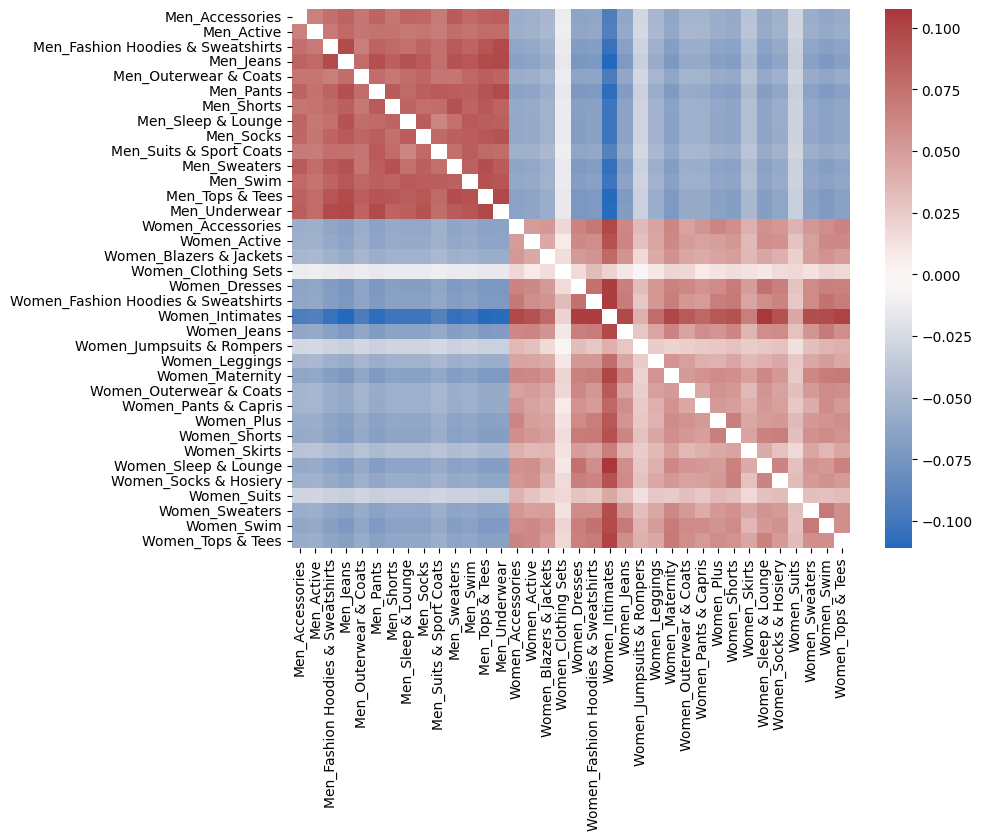

In [74]:
plt.figure(figsize=(9,7))
X_cats_corr = X_cats.corr()
m_diag = np.diag(np.diag(np.ones(X_cats_corr.shape, np.bool)))
X_cats_corr.values[m_diag] = None
sns.heatmap(X_cats_corr, cmap='vlag')

# Dimensionality Reduction with Autoencoders

In [75]:
sys.path.insert(0, '../src/torch_modules')

from autoencoder import Autoencoder, AutoencoderTrainer
from lrp import LinearLRP

In [76]:
X_train, X_test = train_test_split(X_cats, test_size=0.1, random_state=RANDOM_STATE)
X_train, X_valid = train_test_split(X_train, test_size=0.1, random_state=RANDOM_STATE)

In [77]:
scaler_autoencoder = RobustScaler()
X_train_scaled = scaler_autoencoder.fit_transform(X_train)
X_valid_scaled = scaler_autoencoder.transform(X_valid)
X_test_scaled = scaler_autoencoder.transform(X_test)
X_pred_scaled = np.concat([X_train_scaled, X_valid_scaled, X_test_scaled])

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_valid_scaled = torch.tensor(X_valid_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
X_pred_scaled = torch.tensor(X_pred_scaled, dtype=torch.float32)

dataset_train = TensorDataset(X_train_scaled)
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)

dataset_valid = TensorDataset(X_valid_scaled)
valid_loader = DataLoader(dataset_valid, batch_size=64, shuffle=True)

In [179]:
model = Autoencoder(X_train_scaled.shape[1], [20], 6)
model.encoder, model.decoder

(Sequential(
   (0): Linear(in_features=36, out_features=20, bias=True)
   (1): ReLU()
   (2): Linear(in_features=20, out_features=6, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=6, out_features=20, bias=True)
   (1): ReLU()
   (2): Linear(in_features=20, out_features=36, bias=True)
 ))

In [180]:
trainer = AutoencoderTrainer(model)
trainer.train(train_loader, valid_loader)

Using device: cpu
Epoch 1/1000, Validation Loss: 0.035789665
Epoch 2/1000, Validation Loss: 0.032664725
Epoch 3/1000, Validation Loss: 0.030541192
Epoch 4/1000, Validation Loss: 0.029198974
Epoch 5/1000, Validation Loss: 0.028598037
Epoch 6/1000, Validation Loss: 0.027824030
Epoch 7/1000, Validation Loss: 0.027284283
Epoch 8/1000, Validation Loss: 0.026881868
Epoch 9/1000, Validation Loss: 0.026557931
Epoch 10/1000, Validation Loss: 0.026579054
Epoch 11/1000, Validation Loss: 0.026428862
Epoch 12/1000, Validation Loss: 0.026244963
Epoch 13/1000, Validation Loss: 0.026213364
Epoch 14/1000, Validation Loss: 0.026063342
Epoch 15/1000, Validation Loss: 0.026061242
Epoch 16/1000, Validation Loss: 0.025928854
Epoch 17/1000, Validation Loss: 0.025785146
Epoch 18/1000, Validation Loss: 0.026278622
Epoch 19/1000, Validation Loss: 0.025598229
Epoch 20/1000, Validation Loss: 0.025655550
Epoch 21/1000, Validation Loss: 0.025546426
Epoch 22/1000, Validation Loss: 0.025359418
Epoch 23/1000, Validati

np.float64(0.02333934609242509)

In [181]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = model(X_test_scaled)
test_loss = mse_loss(decoded, X_test_scaled)
test_loss

tensor(0.0230, grad_fn=<MseLossBackward0>)

In [182]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = model(X_pred_scaled)
pred_loss = mse_loss(decoded, X_pred_scaled)
pred_loss

tensor(0.0228, grad_fn=<MseLossBackward0>)

In [183]:
X_encoded = encoded.detach().numpy()
X_encoded

array([[-0.88497204,  0.06267539,  0.55911225, -0.327777  , -0.07374835,
        -0.33126882],
       [ 0.1782705 ,  0.11841559,  1.0957136 ,  0.0869548 , -0.62843084,
         0.61254674],
       [-1.5237956 ,  1.0238876 ,  0.09966892,  0.3374689 ,  2.05182   ,
        -4.618659  ],
       ...,
       [-1.4640458 , -0.02348581,  1.0181444 ,  0.22811289,  1.6098552 ,
         0.2055331 ],
       [ 1.206538  ,  0.4606422 ,  1.7870897 , -0.42681774, -0.18866313,
        -0.012289  ],
       [ 0.34160614,  0.00825462,  1.2636981 , -0.18131533,  0.24840033,
         0.46919382]], dtype=float32)

In [184]:
pd.DataFrame(X_encoded).describe()

,0,1,2,3,4,5
count,80044.000000,80044.000000,80044.000000,80044.000000,80044.000000,80044.000000
mean,-0.263039,-0.051707,1.148145,0.000004,0.669759,-0.555849
std,1.175901,0.594786,1.089306,0.630758,1.630588,1.194161
min,-7.021113,-3.351204,-2.782632,-2.781508,-4.450167,-9.102473
25%,-1.009029,-0.401777,0.587445,-0.443480,-0.246858,-1.282619
50%,0.180792,-0.036508,0.953031,-0.056877,0.199207,-0.175721
75%,0.421532,0.112852,1.604782,0.257310,1.189552,0.205533
max,4.900771,3.164924,9.592141,5.642169,14.824070,3.230041


# Explaining Encodings with LRP

In [185]:
def make_explanation_df(X, lrp_out, encoded):
    input_np =  X.values
    lrp_np = lrp_out.numpy()
    encoded_np = encoded.detach().numpy()
    data_explain = np.concat([input_np, lrp_np, encoded_np], axis=1)
    
    len_encoding = encoded_np.shape[1]
    input_cols = X.columns.tolist()
    relevance_cols = [f'rel_{col}' for col in input_cols]
    encoding_cols = [f'encoding_{i}' for i in range(len_encoding)]
    explanation_cols = input_cols + relevance_cols + encoding_cols
    columns_map = dict(
        input_cols = input_cols,
        relevance_cols = relevance_cols,
        encoding_cols = encoding_cols
    )
    
    df_explain = pd.DataFrame(data_explain, columns=explanation_cols)
    return df_explain, columns_map

In [186]:
def explanation_corrs(df_explain, columns_map, corr_thresh=0.05):
    input_cols = columns_map.get('input_cols')
    relevance_cols = columns_map.get('relevance_cols')
    encoding_cols = columns_map.get('encoding_cols')
    
    input_relevance_corr = np.diagonal(df_explain.corr().loc[input_cols, relevance_cols])
    data_input_relevance = {
        'column': input_cols,
        'input_relevance_correlation': input_relevance_corr
    }
    input_relevance_corr = pd.DataFrame(data_input_relevance).sort_values('input_relevance_correlation', ascending=False)
    relevant_columns = input_relevance_corr.loc[input_relevance_corr['input_relevance_correlation']>=corr_thresh, 'column'].sort_values()

    df_explain_corr = df_explain.corr()

    relevance_corr = df_explain_corr.loc[relevant_columns, relevant_columns].values
    relevance_corr = pd.DataFrame(relevance_corr, index=relevant_columns, columns=relevant_columns)
    
    encoding_corr = df_explain_corr.loc[encoding_cols, encoding_cols].values
    encoding_corr = pd.DataFrame(encoding_corr, index=encoding_cols, columns=encoding_cols)
    
    relevance_encoding_corr = df_explain_corr.loc[relevant_columns, encoding_cols].values
    relevance_encoding_corr[(relevance_encoding_corr<corr_thresh)&(relevance_encoding_corr>=0)] = None
    relevance_encoding_corr[(relevance_encoding_corr>-corr_thresh)&(relevance_encoding_corr<0)] = None
    relevance_encoding_corr = pd.DataFrame(relevance_encoding_corr, index=relevant_columns, columns=encoding_cols)

    corr_dfs = dict(
        input_relevance_corr = input_relevance_corr, 
        relevance_corr = relevance_corr,
        encoding_corr = encoding_corr,
        relevance_encoding_corr = relevance_encoding_corr
    )
    
    return corr_dfs

In [187]:
def plot_explanation_corrs(input_relevance_corr, relevance_corr, encoding_corr, relevance_encoding_corr):    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(input_relevance_corr.set_index('column'), cmap='vlag')
    ax.set_title('Input - Relevance Correlations')
    
    fig = plt.figure(figsize=(7, 7))
    relevance_corr_copy = relevance_corr.copy()
    m_diag = np.diag(np.diag(np.ones(relevance_corr.shape, np.bool)))
    relevance_corr_copy.values[m_diag] = None
    ax = sns.heatmap(relevance_corr_copy, cmap='vlag')
    ax.set_title('Relevance Correlations')
    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(relevance_encoding_corr, cmap='vlag')
    ax.set_title('Relevance - Encoding Correlations')

    fig = plt.figure(figsize=(7, 7))
    encoding_corr_copy = encoding_corr.copy()
    m_diag = np.diag(np.diag(np.ones(encoding_corr_copy.shape, np.bool)))
    encoding_corr_copy.values[m_diag] = None
    ax = sns.heatmap(encoding_corr_copy, cmap='vlag')
    ax.set_title('Encoding Correlations')

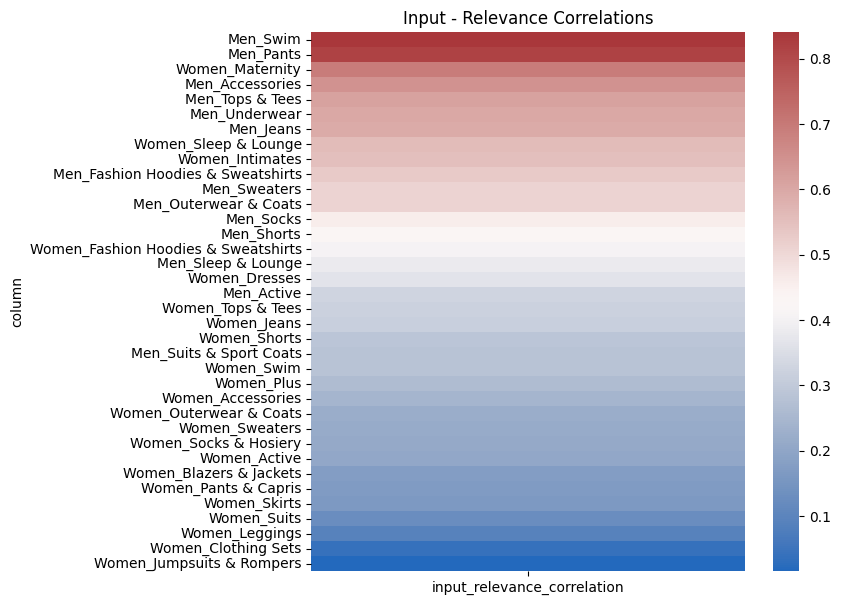

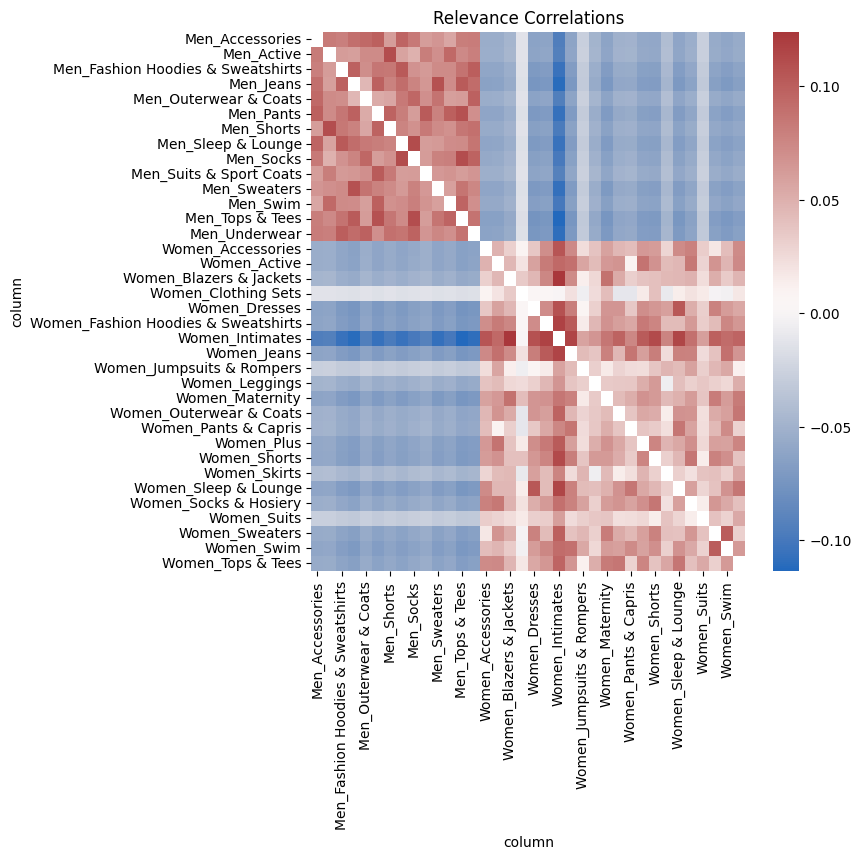

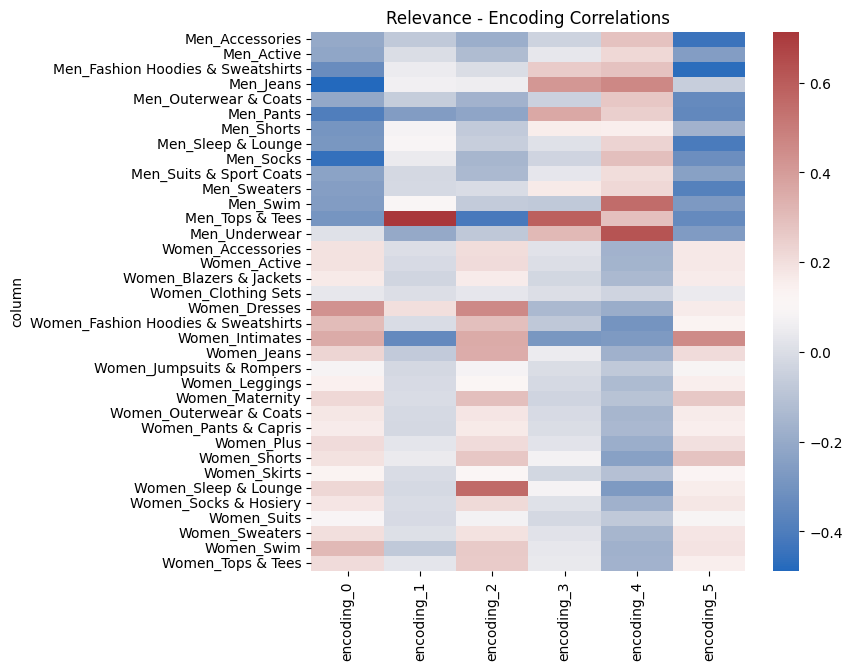

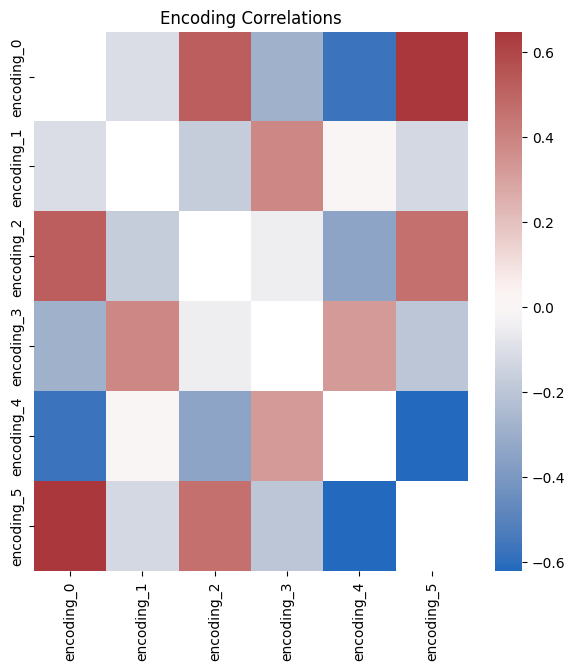

In [190]:
encoded, decoded = model(X_test_scaled)

lrp = LinearLRP(model.encoder, top_k=1)
lrp_out = lrp(X_test_scaled)

df_test_scaled = pd.DataFrame(X_test_scaled.numpy(), columns=X_test.columns)
df_explain, columns_map = make_explanation_df(df_test_scaled, lrp_out, encoded)
corr_dfs = explanation_corrs(df_explain, columns_map, corr_thresh=0)
plot_explanation_corrs(**corr_dfs)

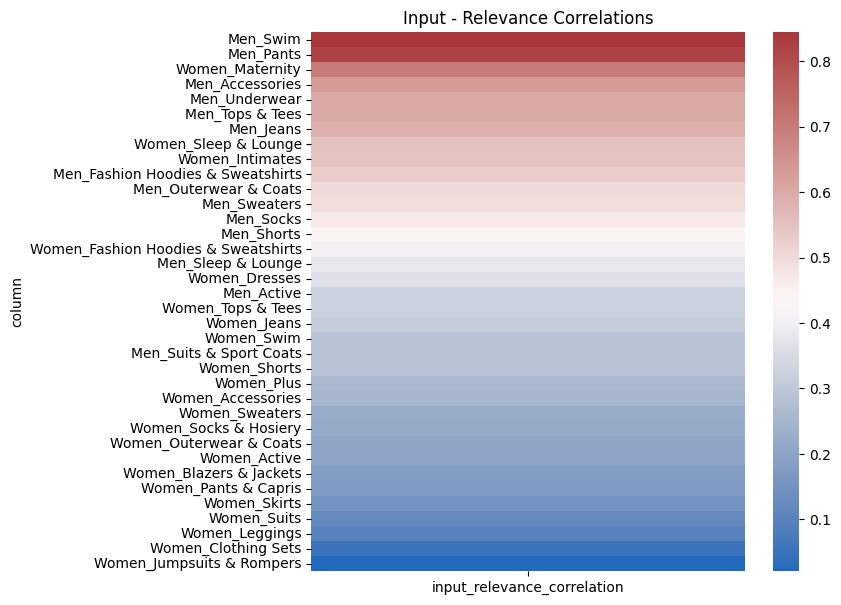

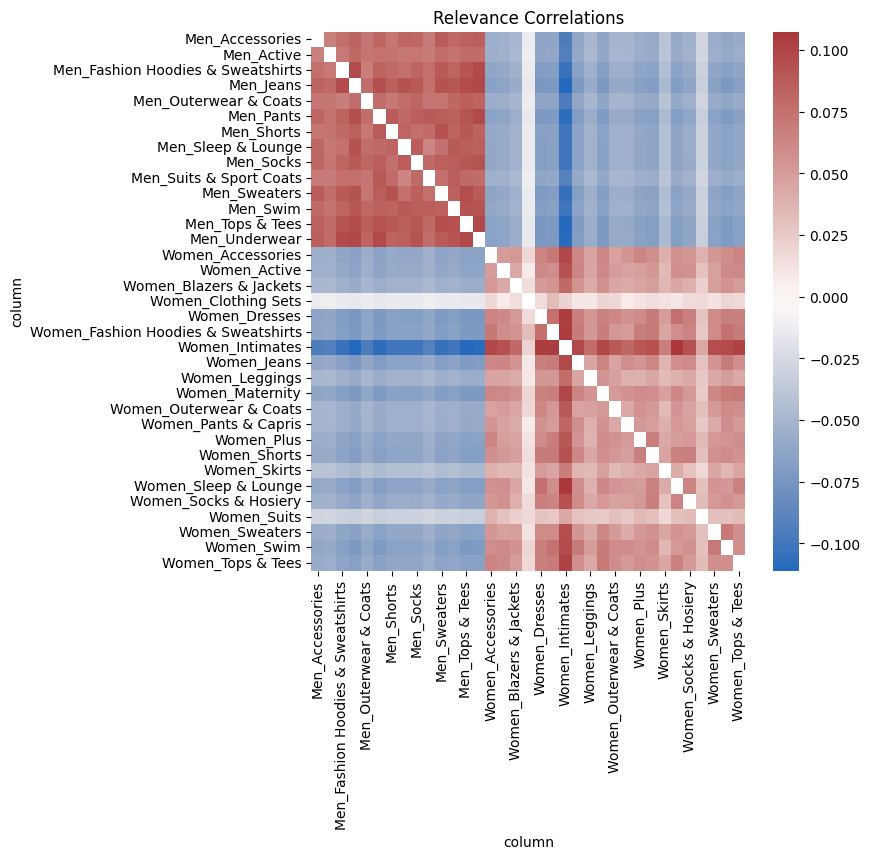

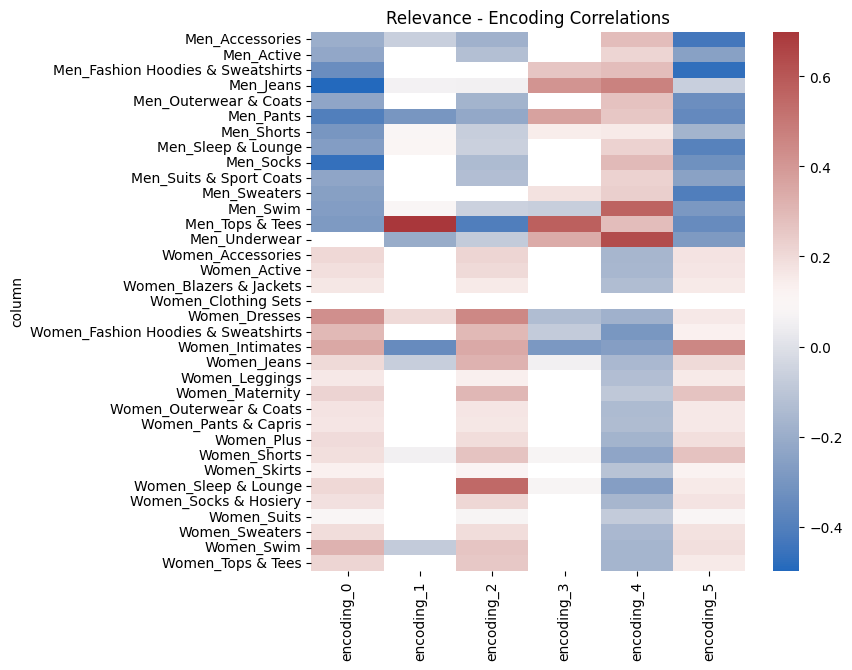

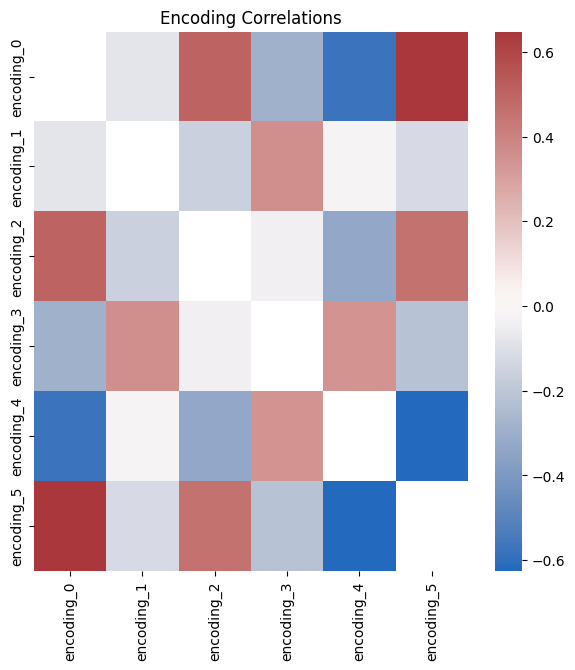

In [191]:
encoded, decoded = model(X_pred_scaled)

lrp = LinearLRP(model.encoder, top_k=1)
lrp_out = lrp(X_pred_scaled)

df_pred_scaled = pd.DataFrame(X_pred_scaled.numpy(), columns=X_test.columns)
df_explain, columns_map = make_explanation_df(df_pred_scaled, lrp_out, encoded)
corr_dfs = explanation_corrs(df_explain, columns_map)
plot_explanation_corrs(**corr_dfs)

# Clustering Customers by Purchased Categories

In [192]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
            
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)

        silhouette = silhouette_score(X, y)
        
        if model_type == KMeans:
            error = model.inertia_ 
        else:
            error = None
            
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model,
            'silhouette_score': silhouette,
            'error': error
        }
        
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Error: {error}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [193]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [194]:
scaler_kmeans = RobustScaler()
X_scaled = scaler_kmeans.fit_transform(X_encoded)
X_scaled

array([[-7.44996846e-01,  1.92727640e-01, -3.87205392e-01,
        -3.86564344e-01, -1.90025896e-01, -1.04524180e-01],
       [-1.76252145e-03,  3.01039040e-01,  1.40251338e-01,
         2.05241829e-01, -5.76184809e-01,  5.29695570e-01],
       [-1.19155109e+00,  2.06050420e+00, -8.38819027e-01,
         5.62715709e-01,  1.28975260e+00, -2.98553991e+00],
       ...,
       [-1.14978445e+00,  2.53037848e-02,  6.40040115e-02,
         4.06668901e-01,  9.82065439e-01,  2.56192863e-01],
       [ 7.17023313e-01,  9.66035545e-01,  8.19845200e-01,
        -5.27891636e-01, -2.70027280e-01,  1.09822035e-01],
       [ 1.12413354e-01,  8.69800970e-02,  3.05373073e-01,
        -1.77569240e-01,  3.42476219e-02,  4.33366090e-01]], dtype=float32)

In [211]:
pca_category = PCA(n_components=0.9)
X_pca = pca_category.fit_transform(X_scaled)
X_pca

array([[ 0.00324816,  0.15591007, -0.9182341 ,  0.04610626],
       [-0.8476254 ,  0.70125616, -0.34792644,  0.5006086 ],
       [ 3.0651398 ,  1.3495125 , -0.3531984 , -1.0861692 ],
       ...,
       [ 0.68192124, -0.08611171,  0.3096598 ,  0.2615585 ],
       [-1.1620226 ,  1.0464133 , -0.13048679, -0.8073965 ],
       [-0.72027934,  0.22518694, -0.15626144, -0.00533189]],
      dtype=float32)

In [212]:
pca_category.explained_variance_ratio_

array([0.427108  , 0.24411258, 0.16115095, 0.07517251], dtype=float32)

In [213]:
X_scaled.shape, X_pca.shape

((80044, 6), (80044, 4))

In [214]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
kmeans_results = search_clustering_hyperparams(KMeans, hyperparams, X_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.32891422510147095 | Error: 292880.125
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.2432125210762024 | Error: 257107.203125
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.33412617444992065 | Error: 175007.125
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.3506568670272827 | Error: 139057.15625
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.35017910599708557 | Error: 128236.7734375
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.35034945607185364 | Error: 115679.2265625
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.314256876707077 | Error: 109503.765625
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.3059554696083069 | Error: 102472.2578125
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.34474286437034607 | Error: 89462.859375


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

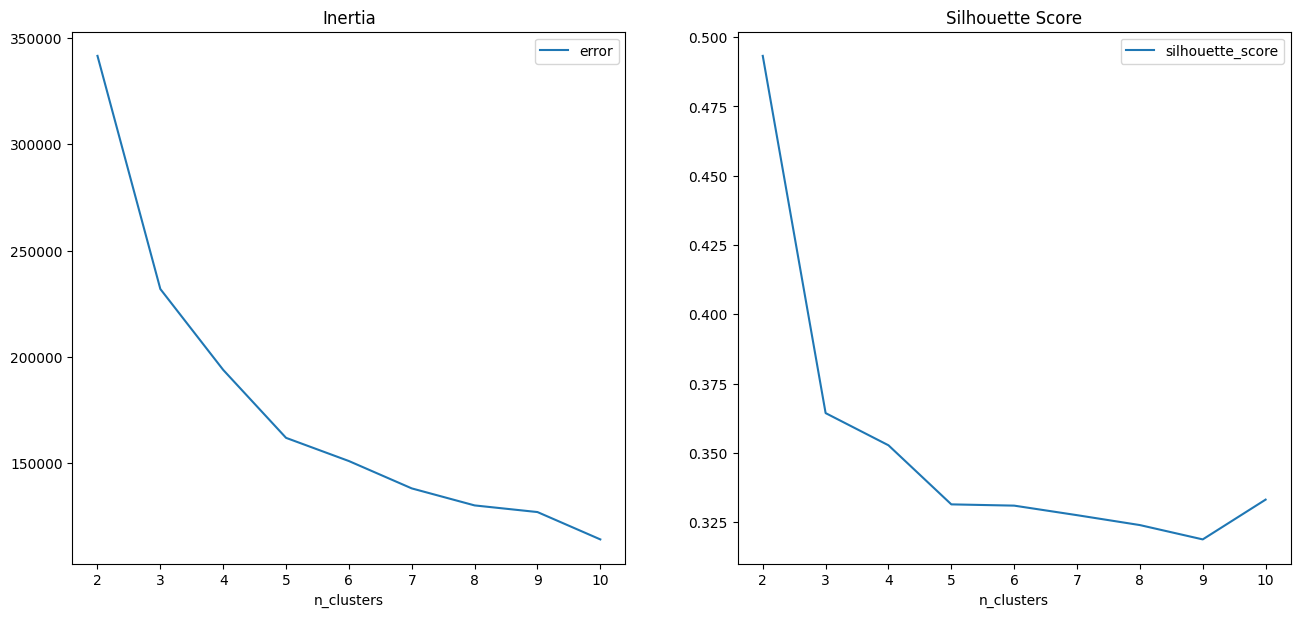

In [206]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)
 
axs[0].set_title('Inertia')
kmeans_results.plot(x='n_clusters', y='error', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [420]:
kmeans = kmeans_results.loc[kmeans_results.n_clusters==6, 'model'].iloc[0]
Xy = pd.DataFrame(X_encoded)
Xy['segment'] = kmeans.labels_

Xy_cats = pd.DataFrame(X_cats)
Xy_cats['segment'] = kmeans.labels_

In [421]:
pd.Series(kmeans.labels_).value_counts()

3    8370
2    3705
1    3518
0    3340
4    1853
5     407
Name: count, dtype: int64

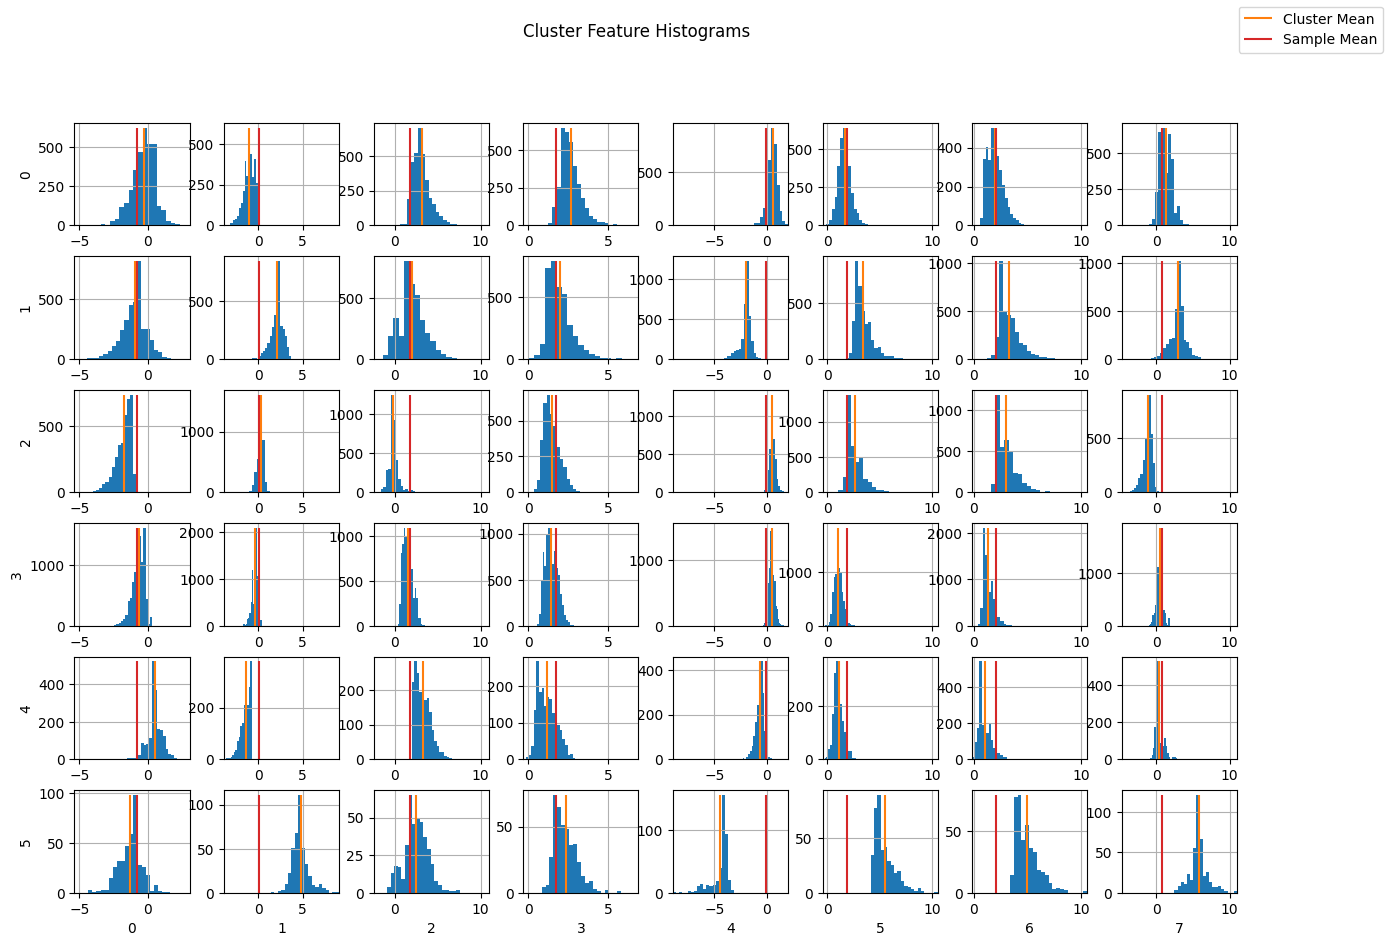

In [422]:
plot_clusters(Xy.drop(columns='segment'), Xy['segment'])

<Axes: xlabel='segment', ylabel='product_category'>

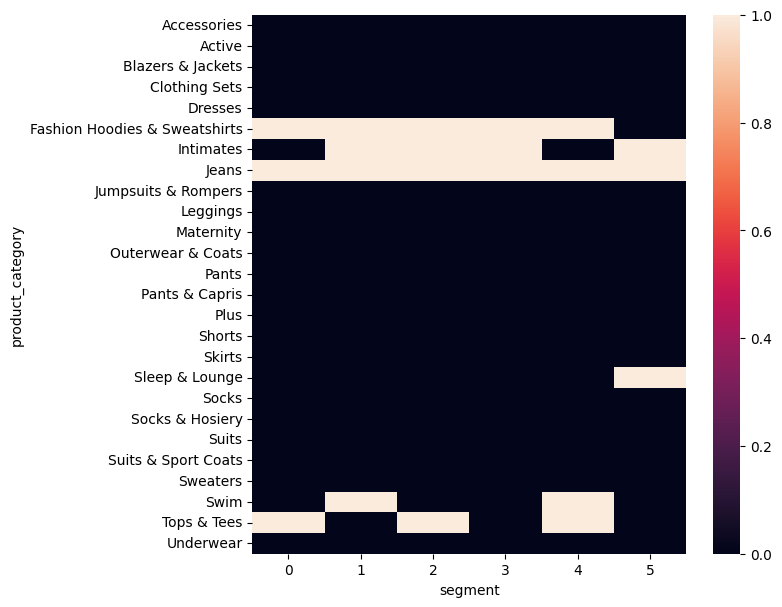

In [423]:
plt.figure(figsize=(7, 7))
sns.heatmap(Xy_cats.groupby('segment').quantile(0.8).T)

In [ ]:
sns.scatterplot(Xy, x='n_orders', y='avg_days_to_order', hue='segment', palette='tab10')

In [ ]:
category_segment_map = {
    0: 'Hoodies & Sweetshirts & Dresses',
    1: '',
    2: '',
    3: '',
    4: '',
}

In [ ]:
repeat_purchasers['loyalty_segment'] = Xy.segment.map(category_segment_map)

In [ ]:
repeat_purchasers.loyalty_segment.value_counts()

In [ ]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='avg_days_to_order', hue='loyalty_segment', palette='tab10')

In [ ]:
sns.scatterplot(repeat_purchasers, x='n_orders', y='std_days_to_order', hue='loyalty_segment', palette='tab10')

## Saving Pipelines

In [ ]:
category_segment_pipe = Pipeline([('scaler', kmeans_scaler), ('kmeans', kmeans)])

In [ ]:
# with open('../models/category_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(category_segment_pipe, f)

In [ ]:
with open('../models/category_segment_pipe.pkl', 'rb') as f:
    category_segment_pipe_loaded = pkl.load(f)

In [ ]:
labels = category_segment_pipe_loaded.predict(X_scaled)
(labels == kmeans.labels_).all()

In [ ]:
with open('../models/category_segment_map.json', 'w') as f:
    json.dump(category_segment_map, f)

In [ ]:
with open('../models/category_segment_map.json', 'r') as f:
    category_segment_map_loaded = json.load(f)

In [ ]:
category_segment_map